In [ ]:
pip install gymnasium

Episode 0: -180534.42030977958
Episode 1: -180501.78051312675
Episode 2: -200438.38258393732
Episode 3: -140531.29542016218
Episode 4: -190417.20110163713
Episode 5: -160515.15150263935
Episode 6: -180420.05086621564
Episode 7: -170502.7455194322
Episode 8: -220435.768197485
Episode 9: -190447.00193660404
Episode 10: -200470.28552907342
Episode 11: -170511.72297660445
Episode 12: -190476.58403653876
Episode 13: -180581.2007831285
Episode 14: -210474.10135291112
Episode 15: -160488.60517869558
Episode 16: -170503.46420546476
Episode 17: -210412.98224256805
Episode 18: -190442.28626649128
Episode 19: -180404.0527358211
Episode 20: -210438.8551153997
Episode 21: -180466.59287386987
Episode 22: -180515.85469447638
Episode 23: -190469.0113844122
Episode 24: -190507.3151929098
Episode 25: -180484.89593960068
Episode 26: -140577.26841420532
Episode 27: -140589.20181660744
Episode 28: -220459.17355876113
Episode 29: -200553.83909701568
Episode 30: -180493.95068697253
Episode 31: -200470.938707

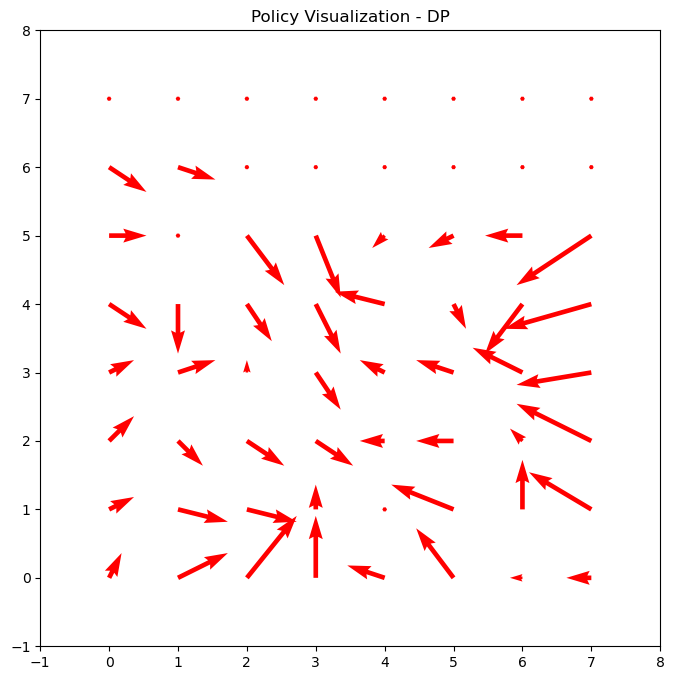

In [3]:
from typing import Any, Dict, List, Tuple
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

class TSPEnvironment(gym.Env):
    """A Gym environment for the Traveling Salesman Problem."""

    def __init__(self, num_targets: int, max_area: int = 30, seed: int = None) -> None:
        super().__init__()
        if seed is not None:
            np.random.seed(seed)

        self.num_targets = num_targets
        self.max_steps = num_targets
        self.max_area = max_area
        self.current_step = 0
        self.visited = []

        self.locations = self._create_random_points(num_targets)
        self.distance_matrix = self._compute_distance_matrix(self.locations)

        low = np.concatenate([
            np.array([0], dtype=np.float32),
            np.zeros(num_targets, dtype=np.float32),
            np.zeros(2 * num_targets, dtype=np.float32)
        ])
        high = np.concatenate([
            np.array([num_targets], dtype=np.float32),
            2 * max_area * np.ones(num_targets, dtype=np.float32),
            max_area * np.ones(2 * num_targets, dtype=np.float32)
        ])
        self.observation_space = gym.spaces.Box(low=low, high=high)
        self.action_space = gym.spaces.Discrete(num_targets)

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[np.ndarray, Dict[str, Any]]:
        self.current_step = 0
        self.current_location = 0
        self.visited = []
        initial_state = self._get_state(self.current_location)
        return initial_state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, Any]]:
        self.current_step += 1
        previous_location = self.current_location
        self.current_location = action
        reward = self._calculate_reward(previous_location, action)
        self.visited.append(action)

        done = self.current_step >= self.max_steps
        next_state = self._get_state(self.current_location)

        return next_state, reward, done, False, {}

    def _create_random_points(self, count: int) -> np.ndarray:
        return np.random.rand(count, 2) * self.max_area

    def _compute_distance_matrix(self, points: np.ndarray) -> np.ndarray:
        return np.linalg.norm(points[:, None] - points[None, :], axis=2)

    def _calculate_reward(self, from_loc: int, to_loc: int) -> float:
        if to_loc not in self.visited:
            return -self.distance_matrix[from_loc, to_loc]
        return -10000  # Large penalty for revisiting

    def _get_state(self, loc: int) -> np.ndarray:
        distances = self.distance_matrix[loc]
        return np.concatenate([np.array([loc]), distances, self.locations.flatten()])

    def value_iteration(self, gamma: float = 0.99, theta: float = 1e-5) -> Tuple[np.ndarray, np.ndarray]:
        value_func = np.zeros(self.num_targets)
        policy = np.zeros(self.num_targets, dtype=int)

        while True:
            delta = 0
            for state in range(self.num_targets):
                action_values = []
                for action in range(self.num_targets):
                    if action != state:
                        reward = -self.distance_matrix[state, action]
                        action_values.append(reward + gamma * value_func[action])
                best_value = max(action_values, default=0)
                delta = max(delta, abs(value_func[state] - best_value))
                value_func[state] = best_value
                policy[state] = np.argmax(action_values)

            if delta < theta:
                break
        return value_func, policy

    def visualize_policy(self, policy: np.ndarray, title: str = "Policy Visualization"):
        grid_size = int(np.ceil(np.sqrt(self.num_targets)))
        X, Y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))

        U = np.zeros_like(X, dtype=float)
        V = np.zeros_like(Y, dtype=float)

        for i in range(self.num_targets):
            row, col = divmod(i, grid_size)
            next_target = policy[i]
            next_row, next_col = divmod(next_target, grid_size)

            U[row, col] = next_col - col
            V[row, col] = next_row - row

        plt.figure(figsize=(8, 8))
        plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', color='r')
        plt.xlim(-1, grid_size)
        plt.ylim(-1, grid_size)
        plt.title(title)
        plt.show()


if __name__ == "__main__":
    num_targets = 50
    env = TSPEnvironment(num_targets)

    episode_returns = []
    for episode in range(100):
        total_reward = 0
        observation = env.reset()[0]
        for _ in range(100):
            action = env.action_space.sample()  # Random action for testing
            next_observation, reward, done, _, _ = env.step(action)
            total_reward += reward
            if done:
                break

        episode_returns.append(total_reward)
        print(f"Episode {episode}: {total_reward}")

    print(f"Average Return over 100 episodes: {np.mean(episode_returns)}")

    value_function, optimal_policy = env.value_iteration()
    print("Optimal Value Function (DP): ", value_function)
    print("Optimal Policy (DP): ", optimal_policy)
    env.visualize_policy(optimal_policy, title="Policy Visualization - DP")
